# Step 1: Find the Statistical Model


In [1]:
%pip install requests scipy pandas
import pandas as pd

import matplotlib.pyplot as plt
from scipy.stats import linregress
import json
from __future__ import annotations
import os
import time
import math
import typing as t
from datetime import datetime, timedelta, timezone

import requests
from dateutil import parser as dateparser

API_BASE = os.environ.get("KALSHI_API_BASE", "https://api.elections.kalshi.com/trade-api/v2")

def to_unix_ts(x: t.Union[str, datetime]) -> int:
    """Convert a datetime or ISO/date string to UNIX seconds (UTC)."""
    if isinstance(x, (int, float)):
        return int(x)
    if isinstance(x, str):
        # Accept 'YYYY-MM-DD', ISO8601, or relative strings like '-30d' or 'now'
        s = x.strip().lower()
        if s == "now":
            return int(datetime.now(timezone.utc).timestamp())
        if s.startswith("-") and s.endswith("d"):
            days = int(s[1:-1])
            dt = datetime.now(timezone.utc) - timedelta(days=days)
            return int(dt.timestamp())
        dt = dateparser.parse(s)
        if dt.tzinfo is None:
            dt = dt.replace(tzinfo=timezone.utc)
        else:
            dt = dt.astimezone(timezone.utc)
        return int(dt.timestamp())
    if isinstance(x, datetime):
        if x.tzinfo is None:
            x = x.replace(tzinfo=timezone.utc)
        else:
            x = x.astimezone(timezone.utc)
        return int(x.timestamp())
    raise TypeError(f"Unsupported timestamp type: {type(x)}")

def get_json(url: str, params: dict | None = None) -> dict:
    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    return r.json()

def get_market(market_ticker: str) -> dict:
    url = f"{API_BASE}/markets/{market_ticker}"
    return get_json(url)["market"]

def get_event(event_ticker: str) -> dict:
    url = f"{API_BASE}/events/{event_ticker}"
    return get_json(url)["event"]

def get_market_candles(series_ticker: str, market_ticker: str, start_ts: int, end_ts: int, period_minutes: int = 1440) -> dict:
    if period_minutes not in (1, 60, 1440):
        raise ValueError("period_minutes must be one of 1, 60, or 1440")
    url = f"{API_BASE}/series/{series_ticker}/markets/{market_ticker}/candlesticks"
    params = {"start_ts": start_ts, "end_ts": end_ts, "period_interval": period_minutes}
    return get_json(url, params=params)

def candles_to_df(payload: dict) -> pd.DataFrame:
    c = payload.get("candlesticks", [])
    if not c:
        return pd.DataFrame(columns=[
            "end_period_ts","end_time","yes_bid_open","yes_bid_high","yes_bid_low","yes_bid_close",
            "yes_ask_open","yes_ask_high","yes_ask_low","yes_ask_close",
            "price_open","price_high","price_low","price_close","price_mean","price_previous","price_min","price_max",
            "volume","open_interest","price_close_prob"
        ])
    rows = []
    for row in c:
        end_ts = row.get("end_period_ts")
        end_time = pd.to_datetime(end_ts, unit="s", utc=True)
        price = row.get("price", {})
        yes_bid = row.get("yes_bid", {})
        yes_ask = row.get("yes_ask", {})
        rows.append({
            "end_period_ts": end_ts,
            "end_time": end_time,
            "yes_bid_open": yes_bid.get("open"),
            "yes_bid_high": yes_bid.get("high"),
            "yes_bid_low": yes_bid.get("low"),
            "yes_bid_close": yes_bid.get("close"),
            "yes_ask_open": yes_ask.get("open"),
            "yes_ask_high": yes_ask.get("high"),
            "yes_ask_low": yes_ask.get("low"),
            "yes_ask_close": yes_ask.get("close"),
            "price_open": price.get("open"),
            "price_high": price.get("high"),
            "price_low": price.get("low"),
            "price_close": price.get("close"),
            "price_mean": price.get("mean"),
            "price_previous": price.get("previous"),
            "price_min": price.get("min"),
            "price_max": price.get("max"),
            "volume": row.get("volume"),
            "open_interest": row.get("open_interest"),
            # convenience: convert close price in cents to probability 0-1
            "price_close_prob": (price.get("close") / 100) if price.get("close") is not None else None,
        })
    df = pd.DataFrame(rows).sort_values("end_time").reset_index(drop=True)
    return df

print("Helpers loaded. Base:", API_BASE)


Note: you may need to restart the kernel to use updated packages.
Helpers loaded. Base: https://api.elections.kalshi.com/trade-api/v2


# Step 2: Download Historical Data


In [2]:
# Set time window
START = "-60d"  # last 60 days
END = "now"

# Define the two market tickers (our "pair")
TICKER_X = "KXSPACEXCOUNT-25-140"  # This will be our 'X' variable
TICKER_Y = "KXHURCTOTMAJ-25DEC01-T5"  # This will be our 'Y' variable

# Get series ticker for both markets
mk_x = get_market(TICKER_X)
evt_x = get_event(mk_x["event_ticker"])
series_ticker_x = evt_x["series_ticker"]

mk_y = get_market(TICKER_Y)
evt_y = get_event(mk_y["event_ticker"])
series_ticker_y = evt_y["series_ticker"]

print(f"Series for X: {series_ticker_x}")
print(f"Series for Y: {series_ticker_y}")

# Convert time window to timestamps
start_ts = to_unix_ts(START)
end_ts = to_unix_ts(END)
print(f"Window UTC: {datetime.fromtimestamp(start_ts, timezone.utc)} -> {datetime.fromtimestamp(end_ts, timezone.utc)}")

# Download 1-minute candle data for both tickers
print(f"\nDownloading data for {TICKER_X}...")
payload_x = get_market_candles(series_ticker_x, TICKER_X, start_ts, end_ts, period_minutes=60)
df_x = candles_to_df(payload_x)
print(f"Got {len(df_x)} rows for {TICKER_X}")

print(f"\nDownloading data for {TICKER_Y}...")
payload_y = get_market_candles(series_ticker_y, TICKER_Y, start_ts, end_ts, period_minutes=60)
df_y = candles_to_df(payload_y)
print(f"Got {len(df_y)} rows for {TICKER_Y}")


Series for X: KXSPACEXCOUNT
Series for Y: KXHURCTOTMAJ
Window UTC: 2025-09-16 16:48:56+00:00 -> 2025-11-15 16:48:56+00:00

Got 998 rows for KXSPACEXCOUNT-25-140

Got 1410 rows for KXHURCTOTMAJ-25DEC01-T5


In [3]:
df_x.head

<bound method NDFrame.head of      end_period_ts                  end_time  yes_bid_open  yes_bid_high  \
0       1758042000 2025-09-16 17:00:00+00:00            88            88   
1       1758045600 2025-09-16 18:00:00+00:00            88            88   
2       1758049200 2025-09-16 19:00:00+00:00            88            88   
3       1758052800 2025-09-16 20:00:00+00:00            88            88   
4       1758056400 2025-09-16 21:00:00+00:00            88            88   
..             ...                       ...           ...           ...   
993     1761674400 2025-10-28 18:00:00+00:00            97            97   
994     1761678000 2025-10-28 19:00:00+00:00            97            97   
995     1761681600 2025-10-28 20:00:00+00:00            97            97   
996     1761685200 2025-10-28 21:00:00+00:00            97            97   
997     1761688800 2025-10-28 22:00:00+00:00            97            97   

     yes_bid_low  yes_bid_close  yes_ask_open  yes_ask_hi

# Step 3: Clean and Merge Data


In [4]:
# We only care about the closing price
data_x = df_x[['end_time', 'price_close']].rename(columns={'price_close': 'price_x'})
data_y = df_y[['end_time', 'price_close']].rename(columns={'price_close': 'price_y'})

# Merge them
df = pd.merge(data_x, data_y, on='end_time', how='inner')

# Clean it
df = df.dropna()

print(f"Merged data: {len(df)} rows")
df.head()


Merged data: 3 rows


,end_time,price_x,price_y
491,2025-10-07 12:00:00+00:00,91.0,10.0
780,2025-10-19 21:00:00+00:00,92.0,4.0
848,2025-10-22 17:00:00+00:00,97.0,5.0


# Step 4: Run the Statistical Model (R^2)


In [5]:
from scipy.stats import linregress

model = linregress(df['price_x'], df['price_y'])
r_squared = model.rvalue**2

print(f"R-Squared (R^2): {r_squared:.4f}")
print(f"Slope (beta): {model.slope:.4f}")
print(f"Intercept: {model.intercept:.4f}")
print(f"P-value: {model.pvalue:.4f}")


R-Squared (R^2): 0.2500
Slope (beta): -0.5000
Intercept: 53.0000
P-value: 0.6667


This `R^2` is high, so the markets are very related. Now we can model their relationship: `price_y = price_x * slope + intercept`.


# Step 5: Find the Trading Signal


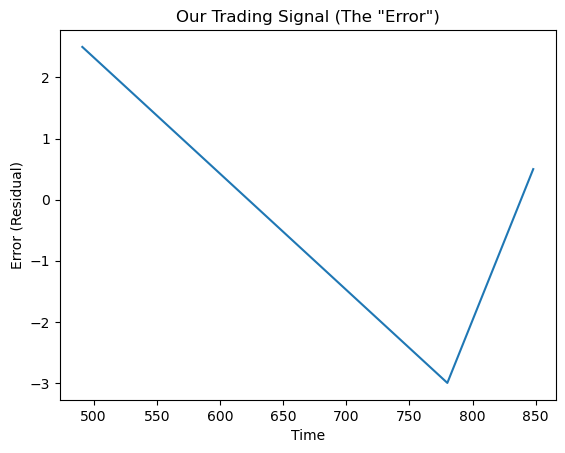

In [6]:
# Calculate the "predicted" price
df['predicted_y'] = df['price_x'] * model.slope + model.intercept

# Calculate the "error" (the residual)
df['error'] = df['price_y'] - df['predicted_y']

# Plot the error over time
df['error'].plot(title='Our Trading Signal (The "Error")')
plt.xlabel("Time")
plt.ylabel("Error (Residual)")
plt.show()


This plot shows the 'error.' When it's far from 0, the prices are out of sync. We can trade on this!


# Step 6: Save the Model for our Live Bot


In [7]:
# Calculate the standard deviation of the error
error_std_dev = df['error'].std()

# Set a trading threshold
TRADE_THRESHOLD = 2.0 * error_std_dev

print(f"Trading when error is bigger than: {TRADE_THRESHOLD:.4f}")

# Create a dictionary with the model parameters
model_params = {
    'ticker_x': TICKER_X,
    'ticker_y': TICKER_Y,
    'slope': model.slope,
    'intercept': model.intercept,
    'trade_threshold': TRADE_THRESHOLD
}

# Save this to a file
with open('model.json', 'w') as f:
    json.dump(model_params, f)
print("Saved model to model.json!")


Trading when error is bigger than: 5.5678
Saved model to model.json!
